In [4]:
import kagglehub
nancyalaswad90_breast_cancer_dataset_path = kagglehub.dataset_download('nancyalaswad90/breast-cancer-dataset')

print('Data source import complete.')

100%|██████████| 48.6k/48.6k [00:00<00:00, 1.04MB/s]

Extracting files...
Data source import complete.


In [5]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Best params: {'clf__C': 0.5, 'clf__penalty': 'l1'}

== Base metrics (0.50 threshold) ==
Accuracy: 0.979
ROC AUC:  0.998
PR AUC:   0.997

Classification report (0.50 threshold):
              precision    recall  f1-score   support

      benign       0.98      0.99      0.98        90
   malignant       0.98      0.96      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

Confusion matrix (0.50 threshold):
[[89  1]
 [ 2 51]]

Chosen threshold to achieve ≥90% recall:
Threshold: 0.624 | Precision: 1.000 | Recall: 0.925

== Metrics (chosen threshold) ==
              precision    recall  f1-score   support

      benign       0.96      1.00      0.98        90
   malignant       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.9

<Figure size 640x480 with 0 Axes>

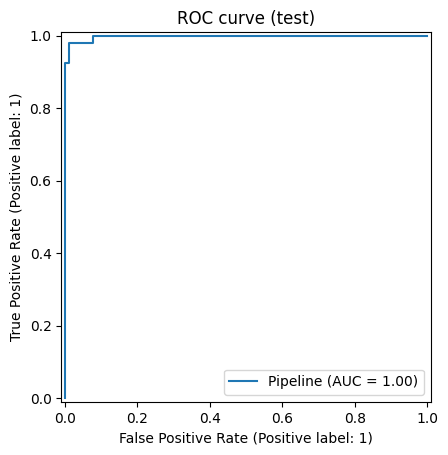


Saved model to breast_cancer_priority_model.joblib


In [6]:
# Simple priority classifier on Breast Cancer data using scikit-learn

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, precision_recall_curve, RocCurveDisplay
)
import matplotlib.pyplot as plt
from joblib import dump

# 1) Load data
data = pd.read_csv(nancyalaswad90_breast_cancer_dataset_path + "/data.csv")
X = data.drop(columns=["diagnosis"])
y = data["diagnosis"]  # 1=malignant, 0=benign in sklearn dataset

# For clarity, re-encode: malignant → 1 (HIGH risk), benign → 0 (LOW risk)
# (Already in that orientation for sklearn; keeping the comment to be explicit.)
y = y.map({'M': 1, 'B': 0})

# 2) Train/val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 3) Pipeline & search space
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="liblinear"))
])

param_grid = {
    "clf__C": [0.1, 0.5, 1.0, 2.0, 5.0],
    "clf__penalty": ["l1", "l2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# primary scoring on ROC AUC, keep PR AUC as secondary metric
gs = GridSearchCV(
    pipe,
    param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)
gs.fit(X_train, y_train)

best_model = gs.best_estimator_
print(f"Best params: {gs.best_params_}")

# 4) Evaluate (probabilities & metrics)
proba_test = best_model.predict_proba(X_test)[:, 1]  # P(malignant)
pred_test_50 = (proba_test >= 0.50).astype(int)

print("\n== Base metrics (0.50 threshold) ==")
print(f"Accuracy: {accuracy_score(y_test, pred_test_50):.3f}")
print(f"ROC AUC:  {roc_auc_score(y_test, proba_test):.3f}")
print(f"PR AUC:   {average_precision_score(y_test, proba_test):.3f}")
print("\nClassification report (0.50 threshold):")
print(classification_report(y_test, pred_test_50, target_names=["benign","malignant"]))
print("Confusion matrix (0.50 threshold):")
print(confusion_matrix(y_test, pred_test_50))

# 5) Choose a threshold to prioritize recall for malignant cases
#    We'll choose the *highest precision* subject to recall >= target_recall.
target_recall = 0.90
prec, rec, thr = precision_recall_curve(y_test, proba_test)
# precision_recall_curve returns len(thr)+1 points for prec/rec; we align thresholds accordingly
candidates = []
for p, r, t in zip(prec[:-1], rec[:-1], thr):  # ignore last prec/rec which have no threshold
    if r >= target_recall:
        candidates.append((t, p, r))
if len(candidates) == 0:
    chosen_threshold = 0.50  # fallback
else:
    # pick threshold with max precision given recall >= target
    chosen_threshold, chosen_precision, chosen_recall = max(candidates, key=lambda x: x[1])
    print(f"\nChosen threshold to achieve ≥{target_recall:.0%} recall:")
    print(f"Threshold: {chosen_threshold:.3f} | Precision: {chosen_precision:.3f} | Recall: {chosen_recall:.3f}")

pred_test_th = (proba_test >= chosen_threshold).astype(int)
print("\n== Metrics (chosen threshold) ==")
print(classification_report(y_test, pred_test_th, target_names=["benign","malignant"]))
print("Confusion matrix (chosen threshold):")
print(confusion_matrix(y_test, pred_test_th))

# 6) Map probabilities → priority tiers
#    Simple rule-of-thumb:
#    - HIGH:   proba >= chosen_threshold (recall-focused threshold)
#    - MEDIUM: 0.50 <= proba < chosen_threshold  (borderline cases)
#    - LOW:    proba < 0.50
def map_priority(p):
    if p >= chosen_threshold:
        return "HIGH"
    elif p >= 0.50:
        return "MEDIUM"
    else:
        return "LOW"

priority_labels = np.vectorize(map_priority)(proba_test)
priority_df = pd.DataFrame({
    "true_label": y_test.map({0: "benign", 1: "malignant"}).values,
    "prob_malignant": proba_test,
    "priority": priority_labels
}).reset_index(drop=True)

print("\nPriority distribution (test set):")
print(priority_df["priority"].value_counts())

# 7) Quick visualization (optional)
plt.figure()
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC curve (test)")
plt.show()

# 8) Save the model (optional)
dump(best_model, "breast_cancer_priority_model.joblib")
print("\nSaved model to breast_cancer_priority_model.joblib")

# 9) Example: scoring new items
# new_scores = best_model.predict_proba(new_X)[:, 1]
# new_priorities = [map_priority(p) for p in new_scores]